## IMBD Sentiment Analysis


##### Importing the libraries


In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from load_data import Read_Files_train, Read_Files_test
from preprocessing_data import process_data
from sklearn.feature_extraction.text import CountVectorizer  
from sklearn.feature_extraction.text import TfidfTransformer  
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from matplotlib import pyplot
import matplotlib.pyplot as plt
from graphplots import graph_plots
import warnings
warnings.filterwarnings("ignore")
import time

##### Reading the data from pos and neg folder for training and test folder for testing. 
##### The directory of the folders should match

In [2]:
print("Reading of the data files on process...")
train_pos = pd.DataFrame(Read_Files_train('Pos','train/pos/*.txt'))
train_pos.columns = ['comment']
train_pos['pos_neg'] = 1
train_neg = pd.DataFrame(Read_Files_train('Neg','train/neg/*.txt'))
train_neg.columns = ['comment']
train_neg['pos_neg'] = 0
X_datatrain_posneg = pd.concat([train_pos,train_neg])
test =  Read_Files_test('Test','test/*.txt')
test['order'] = pd.to_numeric(test['order'])
test = test.sort_values('order', ascending=True)
test = test.reset_index()
X_datatrain = X_datatrain_posneg['comment']
y_datatrain = X_datatrain_posneg['pos_neg']
X_datatest = test['comment']    
print("Task Completed")

Reading of the data files on process...
Task Completed


##### Cleaning of the data is done here. It involves:  
        a) Removing the noise (Punctuations, Numbers, Special characters etc) 
        b) Identifying simple negations  
        c) Lemmatization  
        d) Removing the stopwords (from en_stopwords.txt file)

In [3]:
print("Cleaning of Training data on process...")
cleandata_Train = process_data(X_datatrain)
print("Task completed")
print("Cleaning of Testing data on process...")
cleandata_Test = process_data(X_datatest)
print("Task completed")

Cleaning of Training data on process...


progress-bar: 100%|█████████████████████████████████████████████████████████████| 25000/25000 [00:49<00:00, 507.05it/s]


Task completed
Cleaning of Testing data on process...


progress-bar: 100%|█████████████████████████████████████████████████████████████| 25000/25000 [00:46<00:00, 537.74it/s]


Task completed


##### Function to save predicted value in csv and to show accuracy and confusion matrix

In [4]:
def save2csv(y_pred_test):
    rawdata= { 'CLASSIFIER': y_pred_test }
    a = pd.DataFrame(rawdata, columns = ['category'])
    return a.to_csv('yPred.csv',index=True, header=True)


def confusion_matrix(ypred, y_test):
    from sklearn.metrics import classification_report, confusion_matrix
    print(confusion_matrix(y_test , ypred))  
    print(classification_report(y_test,ypred))  
    print(accuracy_score(y_test, ypred)) 
    Accuracy = accuracy_score(y_test, ypred)
    return Accuracy

##### List of classifiers
     We have used the following models  in our project.
                  1. Linear SVC, 
                  2. Logistic Regression, 
                  3. Ridge Classifier, 
                  4. Stochastic Gradient Descent,
                  5. Multinominal Naive Bayes, 
                  6. Decision tree,
                  7. Naive Bayes SVM,
                  8. Bernoulli Naive Bayes from scratch,
                    
    Note:  Please run imdb.main.py for Bernoulli Naive Bayes from scratch and Naive Bayes SVM in case of Memory error, while                  running in Jupyter Environment
#### Also we have used Linear SVC, Logistic Regression, Ridge classifier and Stochastic Gradient Descent with ensemble model.
        

##### Linear SVC Model

In [5]:
#Count Vectorization with tfidf transformer:
vectorizer = CountVectorizer(analyzer='word', min_df=2,max_df= 0.9, ngram_range=(1, 3))  
X_train_vect = vectorizer.fit_transform(cleandata_Train) 
X_test_vect = vectorizer.transform(cleandata_Test) 

tfidfconverter = TfidfTransformer(sublinear_tf=True, use_idf =True, norm='l2')  
X_train_tfidf = tfidfconverter.fit_transform(X_train_vect)
X_test_tfidf = tfidfconverter.transform(X_test_vect)


#Spliting the dataset for training and validation:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y_datatrain, test_size=0.16, random_state=42) 

#Linear SVC Model:
Cs = [0.01, 0.1, 0.5, 1, 1.5,2, 2.5, 3 ]
svc_clf = GridSearchCV(LinearSVC(), param_grid=dict(C=Cs), cv=10)
start = time.time()
svc_clf.fit(X_train, y_train)    
print("Best cross-validation score: {:.2f}".format(svc_clf.best_score_))
print("Best parameters: ", svc_clf.best_params_)
print("Best estimator: ", svc_clf.best_estimator_)
svc_clf = svc_clf.best_estimator_
ypred_val_svc = svc_clf.predict(X_test)
y_pred_test_svc = svc_clf.predict(X_test_tfidf)
end =  time.time()
print('Time to train and predict in Linear SVC Model: {}'.format(end-start))
confusion_matrix(ypred_val_svc, y_test)

Best cross-validation score: 0.90
Best parameters:  {'C': 2.5}
Best estimator:  LinearSVC(C=2.5, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Time to train and predict in Linear SVC Model: 115.09517407417297
[[1780  185]
 [ 152 1883]]
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      1965
           1       0.91      0.93      0.92      2035

   micro avg       0.92      0.92      0.92      4000
   macro avg       0.92      0.92      0.92      4000
weighted avg       0.92      0.92      0.92      4000

0.91575


0.91575

##### Logistic Regression

In [6]:
#Count Vectorization with tfidf transformer:
vectorizer = CountVectorizer(analyzer='word', min_df=2,max_df= 0.9, ngram_range=(1, 3))  
X_train_vect = vectorizer.fit_transform(cleandata_Train) 
X_test_vect = vectorizer.transform(cleandata_Test) 

tfidfconverter = TfidfTransformer(sublinear_tf=True, use_idf =True, norm='l2')  
X_train_tfidf = tfidfconverter.fit_transform(X_train_vect)
X_test_tfidf = tfidfconverter.transform(X_test_vect)


#Spliting the dataset for training and validation:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y_datatrain, test_size=0.16, random_state=42) 

#Logistic Regression
param_grid = {'C': [1, 10, 100, 1000 ]}
grid = GridSearchCV(LogisticRegression(solver='lbfgs',multi_class='multinomial',random_state=0), param_grid, cv=10)
start = time.time()
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
lr = grid.best_estimator_
ypred_val_lr = lr.predict(X_test)
y_pred_test_lr=lr.predict(X_test_tfidf)
end =  time.time()
print('Time to train and predict in Logistic Regression Model: {}'.format(end-start))
confusion_matrix(ypred_val_lr, y_test)

Best cross-validation score: 0.90
Best parameters:  {'C': 1000}
Best estimator:  LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
Time to train and predict in Logistic Regression Model: 1337.3126420974731
[[1772  193]
 [ 154 1881]]
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1965
           1       0.91      0.92      0.92      2035

   micro avg       0.91      0.91      0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.91      0.91      0.91      4000

0.91325


0.91325

##### Ridge Classifier

In [7]:
#Count Vectorization with tfidf transformer:
vectorizer = CountVectorizer(analyzer='word', min_df=2,max_df= 0.9, ngram_range=(1, 3))  
X_train_vect = vectorizer.fit_transform(cleandata_Train) 
X_test_vect = vectorizer.transform(cleandata_Test) 

tfidfconverter = TfidfTransformer(sublinear_tf=True, use_idf =True, norm='l2')  
X_train_tfidf = tfidfconverter.fit_transform(X_train_vect)
X_test_tfidf = tfidfconverter.transform(X_test_vect)

#Spliting the dataset for training and validation:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y_datatrain, test_size=0.16, random_state=42) 

#Ridge Classifier
param_grid = {'alpha': [0.01, 0.1, 0.5, 1, 2]}
grid = GridSearchCV(RidgeClassifier(class_weight = 'balanced'), param_grid, cv=10)
start = time.time()
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
rc = grid.best_estimator_
ypred_val_rc = rc.predict(X_test)
y_pred_test_rc=rc.predict(X_test_tfidf)
end =  time.time()
print('Time to train and predict in Ridge Classifier Model: {}'.format(end-start))
confusion_matrix(ypred_val_rc, y_test)
save2csv(y_pred_test_rc)

Best cross-validation score: 0.91
Best parameters:  {'alpha': 0.5}
Best estimator:  RidgeClassifier(alpha=0.5, class_weight='balanced', copy_X=True,
        fit_intercept=True, max_iter=None, normalize=False,
        random_state=None, solver='auto', tol=0.001)
Time to train and predict in Ridge Classifier Model: 288.3953981399536
[[1775  190]
 [ 151 1884]]
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1965
           1       0.91      0.93      0.92      2035

   micro avg       0.91      0.91      0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.91      0.91      0.91      4000

0.91475


##### Stochastic Gradient Descent Classifier

In [9]:
#Count Vectorization with tfidf transformer:
vectorizer = CountVectorizer(analyzer='word', min_df=2,max_df= 0.9, ngram_range=(1, 3))  
X_train_vect = vectorizer.fit_transform(cleandata_Train) 
X_test_vect = vectorizer.transform(cleandata_Test) 

tfidfconverter = TfidfTransformer(sublinear_tf=True, use_idf =True, norm='l2')  
X_train_tfidf = tfidfconverter.fit_transform(X_train_vect)
X_test_tfidf = tfidfconverter.transform(X_test_vect)

#Spliting the dataset for training and validation:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y_datatrain, test_size=0.16, random_state=42) 

#SGD Classifier
param_grid = {'alpha': [1e-4, 1e-5, 1e-6]}
grid = GridSearchCV(SGDClassifier(epsilon=0.1), param_grid, cv=10)
start = time.time()
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
sgd = grid.best_estimator_
ypred_val_sgd   = sgd.predict(X_test)
y_pred_test_sgd = sgd.predict(X_test_tfidf)
end =  time.time()
print('Time to train and predict in Stochastic Gradient Descent Model: {}'.format(end-start))
confusion_matrix(ypred_val_sgd, y_test)

Best cross-validation score: 0.90
Best parameters:  {'alpha': 1e-05}
Best estimator:  SGDClassifier(alpha=1e-05, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
Time to train and predict in Stochastic Gradient Descent Model: 11.470661640167236
[[1771  194]
 [ 161 1874]]
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1965
           1       0.91      0.92      0.91      2035

   micro avg       0.91      0.91      0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.91      0.91      0.91      4000

0.91125


0.91125

##### Multionominal Naive Bayes

In [10]:
#Count Vectorization with tfidf transformer:
vectorizer = CountVectorizer(analyzer='word', min_df=2,max_df= 0.9, ngram_range=(1, 3))  
X_train_vect = vectorizer.fit_transform(cleandata_Train) 
X_test_vect = vectorizer.transform(cleandata_Test) 

tfidfconverter = TfidfTransformer(sublinear_tf=True, use_idf =True, norm='l2')  
X_train_tfidf = tfidfconverter.fit_transform(X_train_vect)
X_test_tfidf = tfidfconverter.transform(X_test_vect)

#Spliting the dataset for training and validation:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y_datatrain, test_size=0.16, random_state=42) 

#Multinominal Naive Bayes Classifier:
param_grid = {'alpha': [0.01, 0.1, 1, 1.5]}
grid = GridSearchCV(MultinomialNB(), param_grid, cv=10)
start = time.time()
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
mnb = grid.best_estimator_
ypred_val_mnb   = mnb.predict(X_test)
y_pred_test_mnb = mnb.predict(X_test_tfidf)
end =  time.time()
print('Time to train and predict in Multinominal Naive Bayes Model: {}'.format(end-start))
confusion_matrix(ypred_val_mnb, y_test)

Best cross-validation score: 0.89
Best parameters:  {'alpha': 0.1}
Best estimator:  MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)
Time to train and predict in Multinominal Naive Bayes Model: 13.623932123184204
[[1762  203]
 [ 206 1829]]
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1965
           1       0.90      0.90      0.90      2035

   micro avg       0.90      0.90      0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000

0.89775


0.89775

##### Decision Tree classifier

In [11]:
#Count Vectorization with tfidf transformer:
vectorizer = CountVectorizer(analyzer='word', min_df=2,max_df= 0.9, ngram_range=(1, 3))  
X_train_vect = vectorizer.fit_transform(cleandata_Train) 
X_test_vect = vectorizer.transform(cleandata_Test) 

tfidfconverter = TfidfTransformer(sublinear_tf=True, use_idf =True, norm='l2')  
X_train_tfidf = tfidfconverter.fit_transform(X_train_vect)
X_test_tfidf = tfidfconverter.transform(X_test_vect)

#Spliting the dataset for training and validation:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y_datatrain, test_size=0.16, random_state=42) 

#Decision tree:
start = time.time()
clf_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 100)
clf_entropy.fit(X_train, y_train)
ypred_val_dt = clf_entropy.predict(X_test)
y_pred_test_dt=clf_entropy.predict(X_test_tfidf)
end =  time.time()
print('Time to train and predict in Decision Tree classifier Model: {}'.format(end-start))
confusion_matrix(ypred_val_dt, y_test)

Time to train and predict in Decision Tree classifier Model: 74.65065431594849
[[1370  595]
 [ 574 1461]]
              precision    recall  f1-score   support

           0       0.70      0.70      0.70      1965
           1       0.71      0.72      0.71      2035

   micro avg       0.71      0.71      0.71      4000
   macro avg       0.71      0.71      0.71      4000
weighted avg       0.71      0.71      0.71      4000

0.70775


0.70775

##### Ensemble 

In [15]:
from sklearn.ensemble import VotingClassifier
estimators=[('LinearSVC', svc_clf), ('Logistic_Regression', lr),('Ridge',rc)]
ensemble = VotingClassifier(estimators, voting='hard')
start = time.time()
#Fitting the model on traininf data
ensemble.fit(X_train, y_train)
ypred_val_en   = ensemble.predict(X_test)
y_pred_test_en = ensemble.predict(X_test_tfidf)
end =  time.time()
#test our model on the test data            
ensemble.score(X_test, y_test)
print('Time to train and predict in Ensemble model: {}'.format(end-start))
confusion_matrix(ypred_val_en, y_test)

Time to train and predict in Ensemble model: 42.679465532302856
[[1778  187]
 [ 153 1882]]
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1965
           1       0.91      0.92      0.92      2035

   micro avg       0.92      0.92      0.92      4000
   macro avg       0.92      0.91      0.91      4000
weighted avg       0.92      0.92      0.91      4000

0.915


0.915

##### ROC curve 

     Ref: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

AUC: 0.972


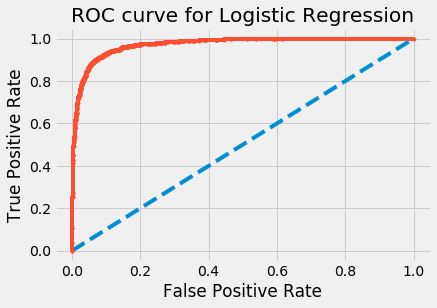

In [42]:
# predict probabilities
probs = lr.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:,1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC curve for Logistic Regression')                     
pyplot.show()

##### Precision-Recall Curves

f1=0.916 auc=0.971 ap=0.971


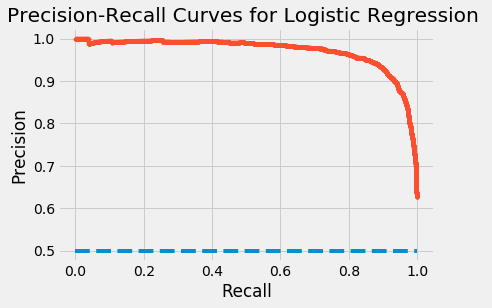

In [40]:
from sklearn.metrics import f1_score
from sklearn.metrics import auc
probs = lr.predict_proba(X_test)
# predict probabilities
probs = lr.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = lr.predict(X_test)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)
# calculate F1 score
f1 = f1_score(y_test, yhat)
# calculate precision-recall AUC
auc = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(y_test, probs)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
# plot no skill
pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the roc curve for the model
pyplot.plot(recall, precision, marker='.')
# show the plot
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall Curves for Logistic Regression ') 
pyplot.show()

##### Wordcloud of negative reviews

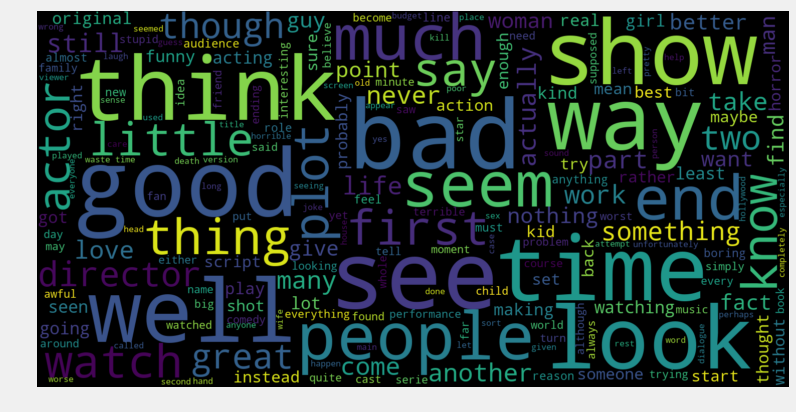

In [23]:
#Word Cloud 
plt.style.use('fivethirtyeight')
from wordcloud import WordCloud, STOPWORDS
stop_words = ['movie','film','scene','make','really','story','made','might','even','one','character'] + list(STOPWORDS)
negative_words = cleandata_Train[12500:]
negative_string = []
for t in negative_words:
    negative_string.append(t)
negative_string = pd.Series(negative_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1500, height=750,max_font_size=190, stopwords=stop_words).generate(negative_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

##### Wordcloud of positive reviews

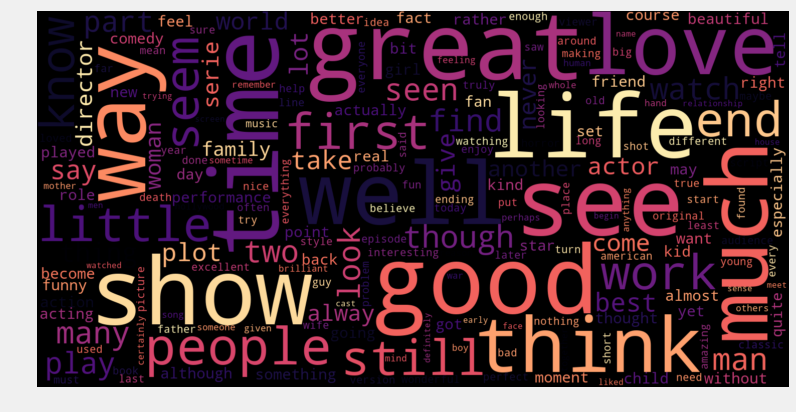

In [24]:
positive_words = cleandata_Train[:12500]
positive_string = []
for t in positive_words:
    positive_string.append(t)
positive_string = pd.Series(positive_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1500, height=750,max_font_size=190,stopwords=stop_words,colormap='magma').generate(positive_string) 
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

##### Table showing the term frequencies of positive and negaitve

In [25]:
import nltk  
nltk.download('stopwords')
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english'))
freqvect = CountVectorizer(min_df = 0.0,max_features= 1000, max_df = 1.0, ngram_range=(1,2),stop_words=stop_words)
freqvect.fit(cleandata_Train)
len(freqvect.get_feature_names())
neg_matrix = freqvect.transform(cleandata_Train[12500:])
pos_matrix = freqvect.transform(cleandata_Train[:12500])
neg_words = neg_matrix.sum(axis=0)
neg_words_freq = [(word, neg_words[0, idx]) for word, idx in freqvect.vocabulary_.items()]
neg_tf = pd.DataFrame(list(sorted(neg_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms','negative'])
neg_tf_df = neg_tf.set_index('Terms')
neg_tf_df.head()
pos_words = pos_matrix.sum(axis=0)
pos_words_freq = [(word, pos_words[0, idx]) for word, idx in freqvect.vocabulary_.items()]
pos_tf = pd.DataFrame(list(sorted(pos_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms','positive'])
pos_tf_df = pos_tf.set_index('Terms')
pos_tf_df.head()
term_freq_df = pd.concat([neg_tf_df,pos_tf_df],axis=1)
term_freq_df['total'] = term_freq_df['negative']  +  term_freq_df['positive'] 
Frequent_words = pd.DataFrame(term_freq_df.sort_values(by='total', ascending=False).head(20))
print(Frequent_words)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Binary\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


        negative  positive  total
one        13572     14167  27739
like       11470      9269  20739
time        7611      8346  15957
would       9081      6734  15815
good        7434      7762  15196
story       5686      7478  13164
even        7684      4962  12646
get         6752      5762  12514
make        6531      5690  12221
see         5632      6380  12012
really      6261      5472  11733
well        4295      6488  10783
scene       5592      4992  10584
much        5077      4688   9765
could       5715      3692   9407
people      4840      4544   9384
bad         7394      1908   9302
also        3606      5550   9156
great       2653      6435   9088
first       4306      4756   9062


##### Frequency plot of top frequent 500 words in movie reviews

Text(0.5, 1.0, 'Top 500 words in movie reviews')

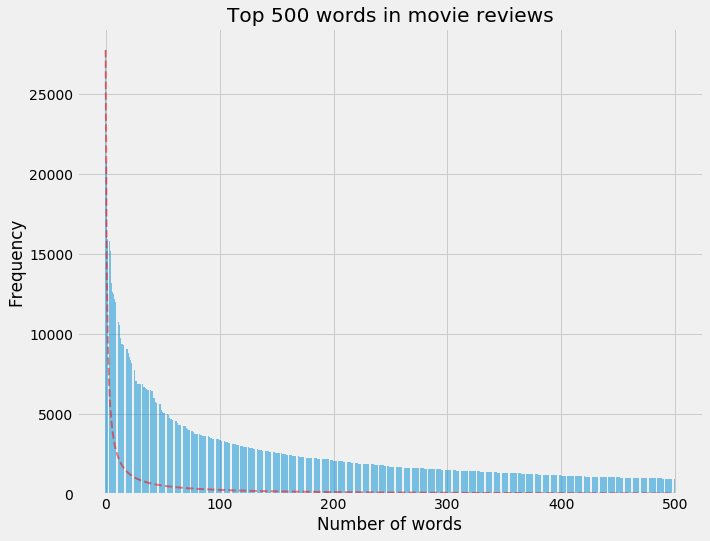

In [26]:
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.xlabel('Number of words')
plt.title('Top 500 words in movie reviews')

#### Task Bernouilli Naive Bayes from Scratch
      P.S: Please run it in imdb_main.py to avoid memory error

In [ ]:
import numpy as np  
from sklearn.base import BaseEstimator

print("Press 1 for laplace smoothing and 0 otherwise")
s = input("Enter the selection: ")
s = int(s)
if s==1:
    LS = True
else:
    LS = False

class BernoulliNBFromScratch(BaseEstimator):      
    def __init__(self, l_smooth = LS):
        """
        Implementation of Bernoulli Naive Bayes from scratch
        """
        self.l_smooth = l_smooth

    def fit(self, X_train, y_train):
        """
        This function fits preprocessed data with the target variable
        """

        # Number of examples where y = 0,1
        No_y_train_1 = np.sum(y_train)
        No_y_train_0 = y_train.shape[0] - No_y_train_1

        #Ratio of Number of examples where y=0,1 and the total number of examples
        self.theta_0 = No_y_train_0/y_train.shape[0]
        self.theta_1 = No_y_train_1/y_train.shape[0]

        #Ratio of Number of examples where x_j =1 and y=0,1 and Number of examples where y=0,1 respectively
        No_inst_j1 = X_train.T.dot(y_train.reshape([-1,1]))  
        No_inst_j0 = X_train.T.dot(1-y_train.reshape([-1,1]))

        #Whether or not laplace smoothing is implemented  or not
        if self.l_smooth:
            self.prob1 = (No_inst_j1 + 1)/(No_y_train_1 + 2)
            self.prob0 = (No_inst_j0 + 1)/(No_y_train_0 + 2)
        else:
            self.prob1 = No_inst_j1/No_y_train_1
            self.prob0 = No_inst_j0/No_y_train_0

        return self

    def predict(self, X_test):
        '''
        This function gives the predicted values depending on the X values
        ''' 
        #Calculation of Prediction: delta function
        del_x = (np.log(self.theta_1/(1-self.theta_1)) + X_test.toarray().dot(np.log(self.prob1/self.prob0)) +/
                 (1-X_test.toarray()).dot(np.log((1-self.prob1)/(1-self.prob0))))

        # If delta function is greater than 0, classify as 1, otherwise as 0
        pred_val = np.zeros(del_x.shape).astype(dtype = 'int')
        pred_val[del_x > 0] = 1

        return pred_val.reshape([-1,])

    def accuracy(self, X_test, y_test, X_test_tfidf):
        '''
        This function gives the accuracy value of the predicted 
        '''
        assert np.array_equal(y_test, y_test.astype(dtype = bool))

        # y validation is predicted
        ypred = self.predict(X_test)

        #y values for test set is predicted
        y_pred_test = self.predict (X_test_tfidf)

        return ypred, y_pred_test


bnb = BernoulliNBFromScratch(l_smooth = LS) 
bnb.fit(X_train, y_train.values)
ypred, y_pred_test = bnb.accuracy(X_test, y_test, X_test_tfidf ) 


##### Task- Model Validation Pipeline with Binary Occurances and TfIdf weighting, LinearSVC

In [39]:
#reference taken from https://github.com/ryan-cranfill/sentiment-pipeline-sklearn/blob/master/sentiment-pipeline-sklearn-5.ipynb
def pipeline_data(cleandata_Train, y_datatrain):
    '''
    This function uses two feature extraction pipelines for processing the text data 
    (binary occurrences vs. tf-idf weighting) with LinearSVC model.
    It also provides us the Model Validation Pipeline.
    '''
    x_train, x_validation, y_train, y_validation = train_test_split(cleandata_Train, y_datatrain, test_size=.16, random_state=2000)
    
    from sklearn.pipeline import Pipeline
    #Pipeline for Binary occurances
    binary_occurance = Pipeline([('vect', CountVectorizer() ),
                                  ('clf', LinearSVC() )])
    
    # Pipeline for Tfidf weighting
    tfidf_weighting = Pipeline([('vect', CountVectorizer() ),
                                ('tfidf', TfidfTransformer() ),
                                ('clf', LinearSVC() )]) 
    #Creating a list of pipeline to see which is better    
    Pipeline_list = {
                        "binary_linearSVC": binary_occurance,
                        "tfidf_linearSVC": tfidf_weighting
                      }
    
    # Assigning the parameters of binary Countvectorizer and Linear SVC
    binary_svc_parameters = { 
                              "vect__binary": [True], 
                              "vect__ngram_range": [(1,3)], 
                              "vect__min_df" : [2],
                              #"vect__max_df":[0.8,0.9],
                              "clf__C": [1, 2.5]
                              }
    # Assigning the parameters of Tfidf and Linear SVC
    tfidf_svc_parameters = {       
                              "vect__ngram_range": [(1,3)], #(1,2),(1,3)
                              "tfidf__use_idf": [True],
                              #"vect__max_df":[0.8,0.9],
                              "vect__min_df" : [2],
                              "clf__C": [ 1, 2.5]
                              }
    # Keeping the parameters in a list
    parameters_list = {
                         "binary_linearSVC": binary_svc_parameters,
                         "tfidf_linearSVC" : tfidf_svc_parameters,
                         }
    
    #Perfroming K-fold cross Validaton by Grid Search CV method keeping the value of CV= 10
    for i in Pipeline_list:
        print('Performing Grid Search for {}'.format(i))
        grid = GridSearchCV(Pipeline_list[i], param_grid = parameters_list[i], cv=10)
        grid.fit(x_train, y_train)
        print("Best cross-validation score: {:.2f}".format(grid.best_score_))
        print("Best parameters: ", grid.best_params_)
        print("Best estimator: ", grid.best_estimator_)
        svc = grid.best_estimator_
        y_pred = svc.predict(x_validation)
        acc_svc=accuracy_score(y_validation, svc.predict(x_validation)) 
        print ("accuracy score: {0:.2f}%".format(acc_svc*100))

pipeline_data(cleandata_Train, y_datatrain)

Performing Grid Search for binary_linearSVC
Best cross-validation score: 0.89
Best parameters:  {'clf__C': 1, 'vect__binary': True, 'vect__min_df': 2, 'vect__ngram_range': (1, 3)}
Best estimator:  Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
accuracy score: 89.65%
Performing Grid Search for tfidf_linearSVC
Best cross-validation score: 0.90
Best parameters:  {'clf__C': 1, 'tfidf__use_idf': True, 'vect__min_df': 2, 'vect__ngram_range': (1, 3)}
Best estimator:  Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, 

#### BEST FIT MODEL: LINEAR SVC

In [43]:
#Linear SVC
ypred_val_svc = svc_clf.predict(X_test)
y_pred_test_svc = svc_clf.predict(X_test_tfidf)
confusion_matrix(ypred_val_svc, y_test)

[[1780  185]
 [ 152 1883]]
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      1965
           1       0.91      0.93      0.92      2035

   micro avg       0.92      0.92      0.92      4000
   macro avg       0.92      0.92      0.92      4000
weighted avg       0.92      0.92      0.92      4000

0.91575


0.91575

#### Save predicted values as CSV

In [38]:
rawdata= { 'Category': y_pred_test_svc }
a = pd.DataFrame(rawdata, columns = ['Category'])
a.to_csv('y_pred.csv',index=True, header=True)